# Decision Trees and Ensembles

### Imports

In [ ]:
!pip install seaborn
!pip install plotly
!pip install cufflinks
!pip install nbformat>=4.2.0
!brew install graphviz

In [2]:
import numpy as np
import pandas as pd
import math
np.random.seed(23)

In [3]:
from IPython import display

In [4]:
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

### Loading the data

For this notebook we will use the generated dataset from scikit learn function. The goal is to predict y variable based on X feature values

In [53]:
X, y = datasets.make_moons(150, random_state=0)
df = pd.DataFrame(dict(feature_one=X[:,0], feature_two=X[:,1], label=y))
df.head()

,feature_one,feature_two,label
0,1.084806,-0.496397,1
1,-0.873014,0.487695,0
2,0.169001,0.985616,0
3,0.789321,-0.477555,1
4,0.956167,0.292823,0


In [54]:
px.scatter(df, x="feature_one", y="feature_two", color="label")

Notice that these two classes cannot be  linear separable

### Logistic regression for binary classification

In [21]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='lbfgs')
lr_model.fit(df[['feature_one', 'feature_two']], df['label'])

LogisticRegression()

In [22]:
y_hat = lr_model.predict(df[['feature_one', 'feature_two']])
accuracy = np.mean(y==y_hat)
print("Prediction Accuracy:", accuracy)

Prediction Accuracy: 0.8666666666666667


We can also visualize the predictions. The following code constructs a plot illustrating the decision we would make for each possible value of ''feature_one'' and ''feature_two''. You don't need to understand the details of the code but the basic idea is evaluate the model on a grid (mesgrid) of features and color the plot the color the integer value for that feature.

In [23]:
def plot_decision_boundaries(model, X, n=50):
    _, z_int = np.unique(y, return_inverse=True)
    # Make contour plot
    u = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, n)
    v = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, n)
    us,vs = np.meshgrid(u, v)
    X_test = np.c_[us.ravel(), vs.ravel()]
    z_str = model.predict(X_test)
    _, z_int = np.unique(z_str, return_inverse=True)
    return go.Contour(x=X_test[:,0], y=X_test[:,1], z=z_int, colorscale=px.colors.qualitative.Plotly[:2],showscale=False)

In the following plot we can see the data points and the predicted class assignment for all combinations of features

In [24]:
fig = px.scatter(df, x="feature_one", y="feature_two", color="label")
fig.update_traces(marker=dict(size=12, line=dict(width=2, color='black')),
                  selector=dict(mode='markers'))
fig.add_trace(
    plot_decision_boundaries(lr_model,
                             df[['feature_one', 'feature_two']].to_numpy())
)

/Users/Iana_Kasimova/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



## Decision tree classification

Decision Trees are a non-parametric supervised machine learning modelling that is widely used for classification problems
(typically as random forests ensemble learning approach). They can also be used for regression problems.
In decision tree learning, we predicts the target value by learning simple decision rules inferred from the data features.
So:
1. Decision tree is a type of model used for both classification and regression (CART).
2. By answering sequential questions, tree send us down along a certain route to find the outcomes / result class.
3. Decision tree model behaves like “if this, then that” conditions ultimately yielding a specific result.


***My son wants to practice soccer. Before I decide to go out with him, I have few questions on weather***

In [39]:
df = pd.DataFrame({'Outlook':['Sunny', 'Overcast', 'Rainy', 'Rainy', 'Sunny'], 'Windy':['T', 'T', 'T', 'T', 'F'], 'Playing':['No', 'Yes', 'Yes', 'No', 'Yes']})
df.head(5)

,Outlook,Windy,Playing
0,Sunny,T,No
1,Overcast,T,Yes
2,Rainy,T,Yes
3,Rainy,T,No
4,Sunny,F,Yes


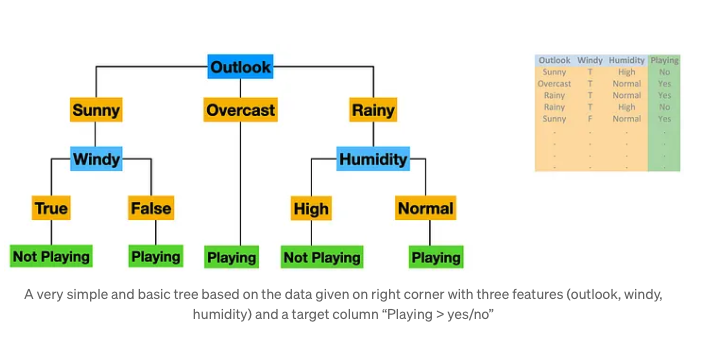

In [26]:
display.Image("data/tree_1.png")

- **Root Node**: The starting point of the tree, e.g. 'Outlook'
- **Branches**: Lines (sometimes shown as arrows) connecting nodes, showing the flow from question to answer — segments of the trees that connect the nodes
- **Leaf Node**: Terminal nodes that predict the outcomes “Playing/Not Playing”
- **Internal nodes**: Nodes that split for the value of a certain feature / attribute >> “Windy” & “Humidity”


- Both the root and the leaf nodes contain questions or criteria to be answered along the route between them 
- **Depth of the tree** is important and represents **how many questions are asked** before we reach the leaf node 
- The overall tree depth is denoted by its **longest route**

1. In our example for each leaf node which depth we have? 
2. Which depth this tree has?

***HOW TO DECIDE A SPLIT, THAT COULD _BE THE BEST_ UNDER THE GIVEN CIRCUMSTANCES?***

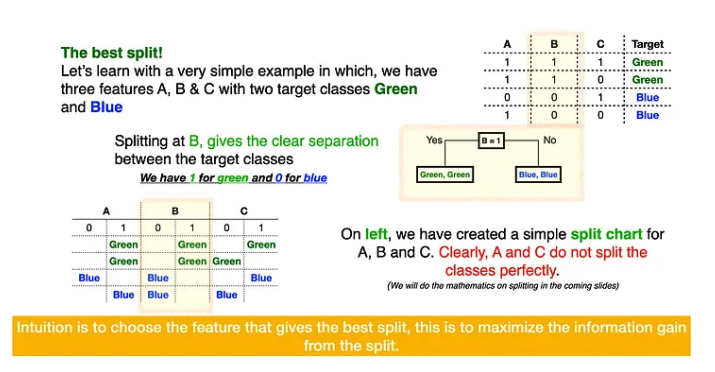

In [27]:
display.Image("data/tree_2.png")

### Splitting criterias

- Entropy & Information Gain
- Gini Index

#### Entropy

* **Entropy** can be roughly thought of as **how much variance the data has**. For example: We have only *Blue* classes, then this dataset will have a small entropy, where we have a mixture not only *green*, *blue*, but also other colors, then we have a very big value of entropy
* **Entropy**  can be considered as *how surprised we will be by the result obtained*

Entropy formula
\begin{align}
  H(X) = -\sum_{x}{p(x) * log_2\,{p(x)}}
\end{align}

p_i = the probability of randomly picking an element of class *i*

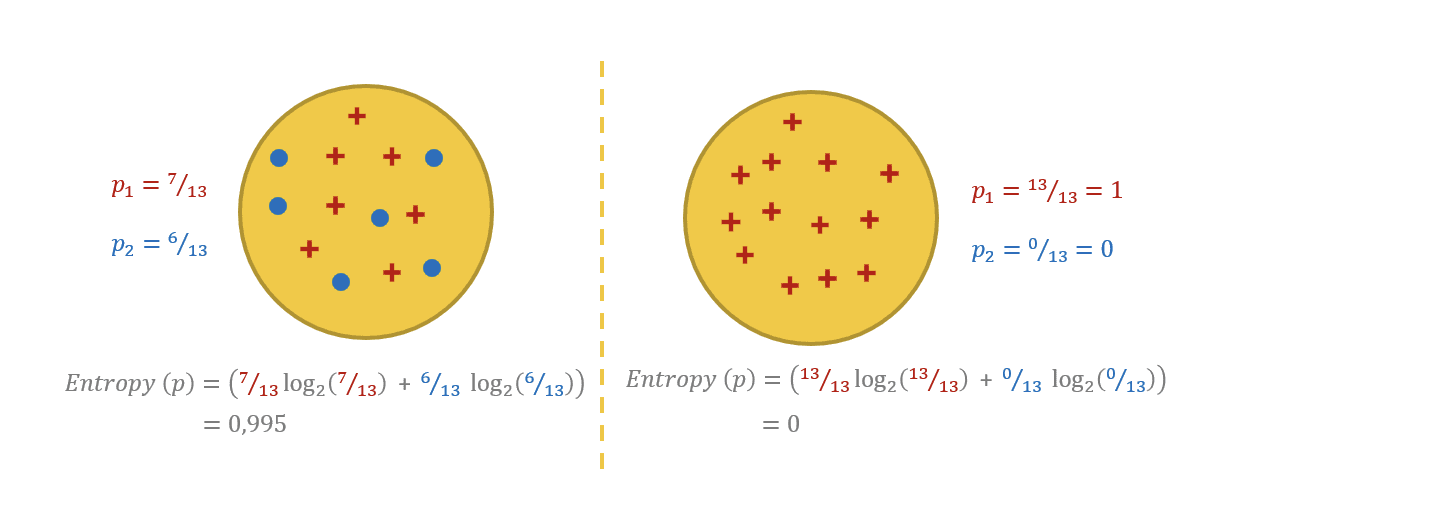

In [6]:
display.Image("data/entropy.png")

##### Entropy vs probability

In the example below, we compare probability of some random variable X and the entropy of that variable.

In [44]:
def entropy(p_x):
    h_sum = float()
    for item in p_x:
        h_sum += item * math.log(item,2)
    return -h_sum

Lenght of x samples: 100


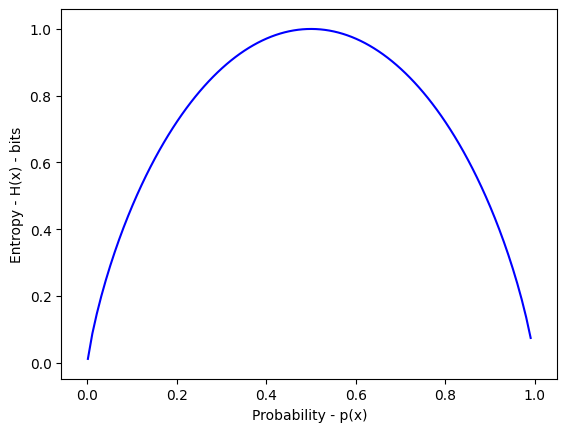

In [47]:
x_r = np.arange(0.001, 0.999, 0.01)
print("Lenght of x samples: %i" % len(x_r))
# starting from 0.001 because log_2(0) not defined
# eg: math.log(0,2) will yield "ValueError: math domain error"

y_r = list(map(lambda x: entropy([x, 1.0-x]), x_r))

plt.plot(x_r, y_r, c='b')
plt.xlabel('Probability - p(x)') #Pr(X=1) ?
plt.ylabel('Entropy - H(x) - bits') #p(x)

plot_margin = 0.01
x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))
plt.show()

What can be seen in this graph is that we get the most **bits of information** when our sets are relatively equal divided (equal probability of encountering either of the classes).

***
Why is that ?
***

Because **when we have the biggest entropy** (approaching 1), we have the **most chaos/impurity in our data**, then we **gain the most information in a random experiment** when we have the **least assurance of predicting which class** will be randomly selected next.
(alternatively, that assurance will be much higher if we know there is only 10% chance of encountering one class versus 90% chance of another).

***Information Gain*** is based on entropy. The information gain decides which feature to split on at each step in building the decision tree.

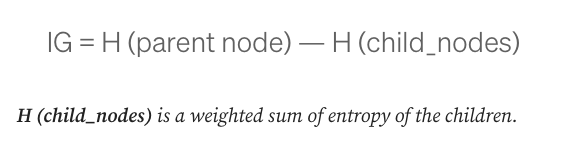

In [29]:
display.Image("data/tree_4.png")

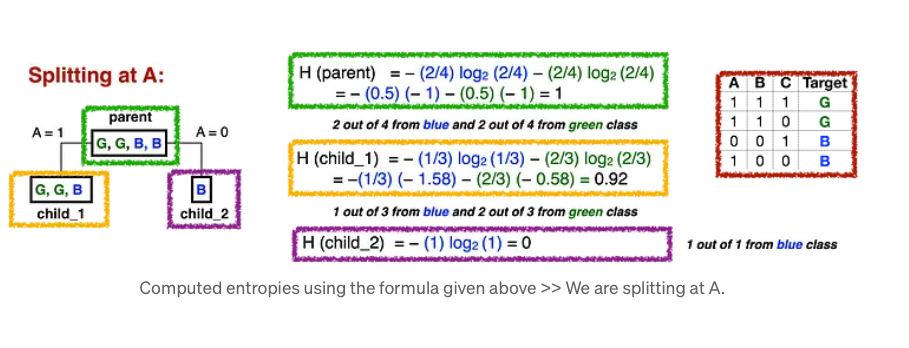

In [30]:
display.Image("data/tree_5.png")

Let’s compute the Information Gain (IG).


\begin{align} IG = H (parent) − {(3/4) H (child_1) + (1/4) H (child_2)} \end{align}



\begin{align} IG = 1 − {(3/4) 0.92 + (1/4) 0} \end{align}

\begin{align} IG = 1 − {0.69 + 0} \end{align}

\begin{align} IG = 1 − 0.69 \end{align}

\begin{align} IG = 0.31 \end{align}

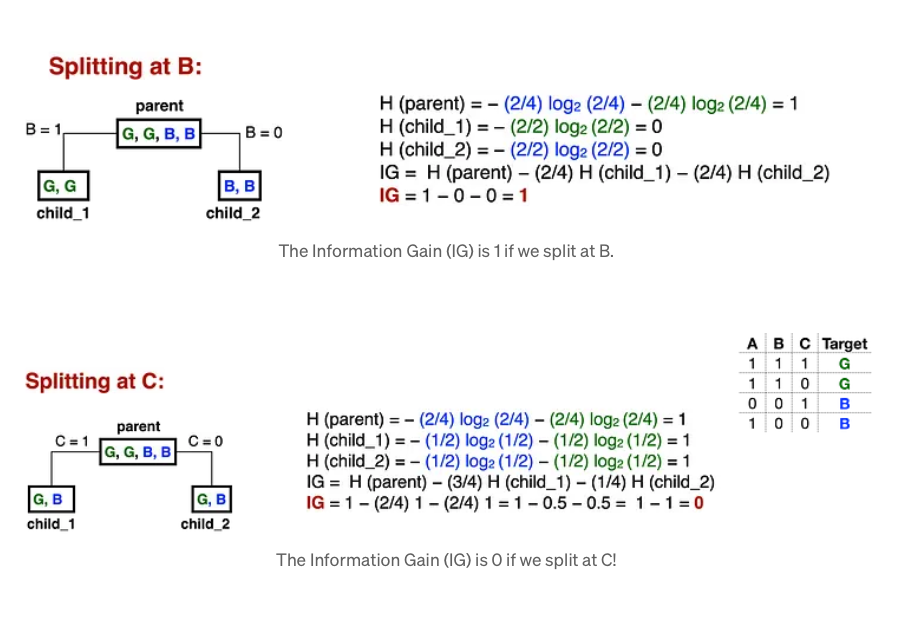

In [31]:
display.Image("data/tree_6.png")

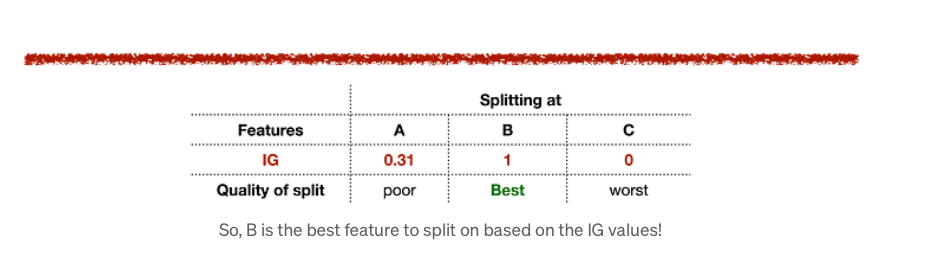

In [32]:
display.Image("data/tree_7.png")

#### Critrea Gini

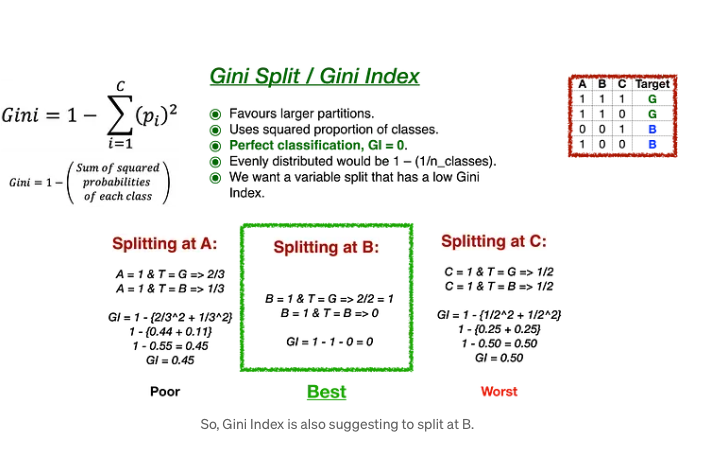

In [33]:
display.Image("data/tree_8.png")

### Decision Tree Classification

In [55]:
from sklearn import tree
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(df[['feature_one', 'feature_two']], df['label'])

DecisionTreeClassifier()

In [56]:
dt_model.predict(df[['feature_one', 'feature_two']])

array([1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

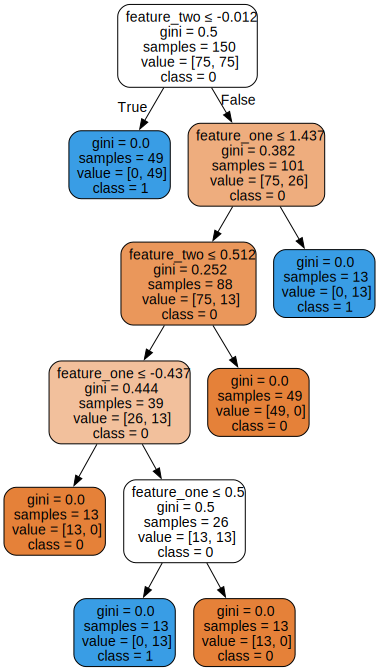

In [62]:
import graphviz
dot_data = tree.export_graphviz(dt_model, out_file=None, 
                      feature_names=['feature_one', 'feature_two'],  
                      class_names=["0", "1"],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)
graph

In [63]:
fig = px.scatter(df, x='feature_one', y='feature_two', color="label")
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.add_trace(
    plot_decision_boundaries(dt_model,
                             df[['feature_one', 'feature_two']].to_numpy())
)

/Users/Iana_Kasimova/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



***
Advanteges
***

???

***
Disadvanteges
***

???

#### Regresiion

1. What will be in the leaf node?
2. What will be the split criteria?

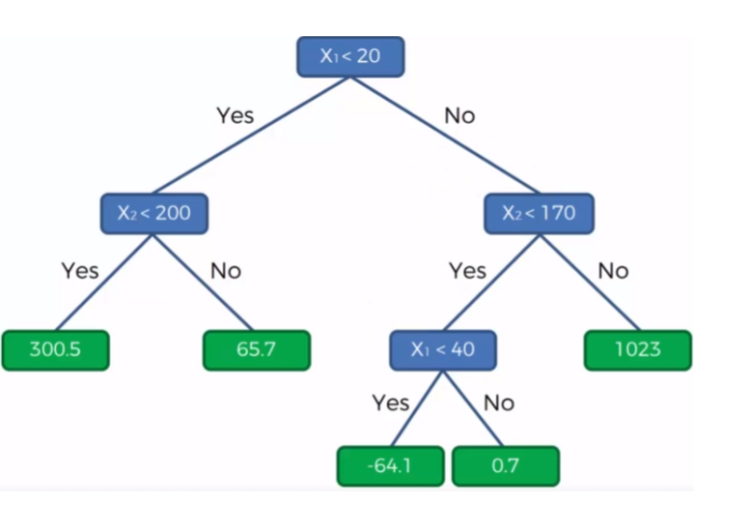

In [74]:
display.Image("data/tree_9.png")

The split criteria will be SSE as for simple linear regression

\begin{align}
\text{SSE}\text{node} = \sum_{i \in \text{left}} (y_i - \hat{y}_l)^2 + \sum_{j \in \text{right}} (y_j - \hat{y}_r)^2 
\end{align}

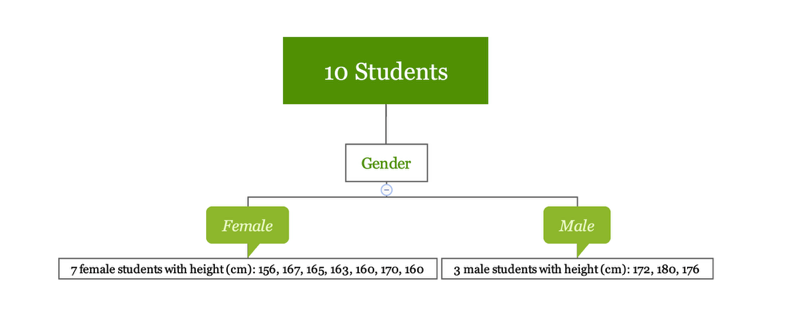

In [75]:
display.Image("data/tree_10.png")


* SSE for “Female” is 136
* SSE for “Male” is 32
* SSE for splitting node “Gender” is the sum of the above two numbers which is 168
* SSE for the 10 students in root node is 522.9. After the split, SSE decreases from 522.9 to 168.

## Ensembles

### The Bootstrap


*Bagging* (also known as [Bootstrap aggregation](https://en.wikipedia.org/wiki/Bootstrap_aggregating)) is one of the first and most basic ensemble techniques. It was proposed by [Leo Breiman](https://en.wikipedia.org/wiki/Leo_Breiman) in 1994. Bagging is based on the statistical method of [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29), which makes the evaluation of many statistics of complex models feasible.

The bootstrap method goes as follows. Let there be a sample $\large X$ of size $\large N$. We can make a new sample from the original sample by drawing $\large N$ elements from the latter randomly and uniformly, with replacement. In other words, we select a random element from the original sample of size $\large N$ and do this $\large N$ times. All elements are equally likely to be selected, thus each element is drawn with the equal probability $\large \frac{1}{N}$.

Let's say we are drawing balls from a bag one at a time. At each step, the selected ball is put back into the bag so that the next selection is made equiprobably i.e. from the same number of balls $\large N$. Note that, because we put the balls back, there may be duplicates in the new sample. Let's call this new sample $\large X_1$.

By repeating this procedure $\large M$ times, we create $\large M$ *bootstrap samples* $\large X_1, \dots, X_M$. In the end, we have a sufficient number of samples and can compute various statistics of the original distribution.

![image](https://habrastorage.org/webt/n0/dg/du/n0dgduav1ygc3iylumtwjcn15mu.png)

Why we need it?

//

for reducing the high variance of machine learning algorithm

Let's generate sinthetic data and try to implement bagging using DecisionTree for regression

In [64]:
import pandas as pd
import numpy as np

# create a random number generator that will be used to set the randomness
rng = np.random.RandomState(1)


def generate_data(n_samples=30):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_min, x_max = -3, 3
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.randn(n_samples)
    y = x**3 - 0.5 * (x + 1) ** 2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"]
    )
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train

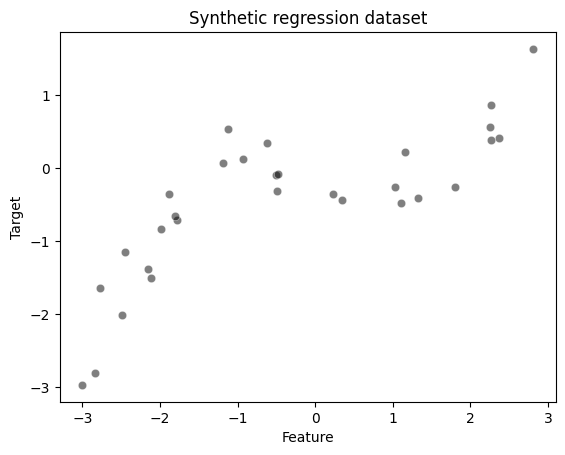

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

data_train, data_test, target_train = generate_data(n_samples=30)
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
_ = plt.title("Synthetic regression dataset")

the relationship not a linear, but we already know that tree models can manage with it

In [66]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)
y_pred = tree.predict(data_test)

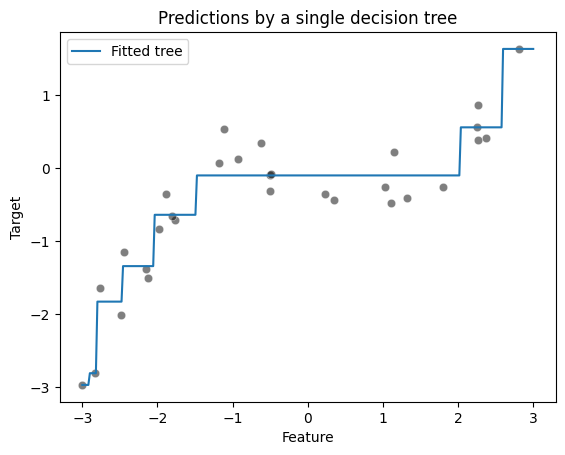

In [67]:
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
plt.plot(data_test["Feature"], y_pred, label="Fitted tree")
plt.legend()
_ = plt.title("Predictions by a single decision tree")

Let's define several trees and try bagging, aka getting average results based on an ensemble of tree models

generate bootstrap sampling

In [68]:
def bootstrap_sample(data, target):
    # Indices corresponding to a sampling with replacement of the same sample
    # size than the original data
    bootstrap_indices = rng.choice(
        np.arange(target.shape[0]),
        size=target.shape[0],
        replace=True,
    )
    # In pandas, we need to use `.iloc` to extract rows using an integer
    # position index:
    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap

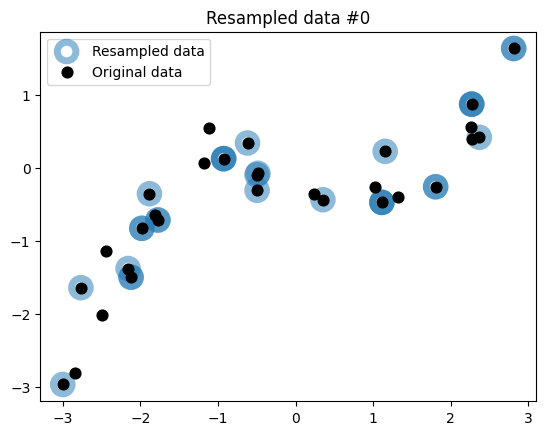

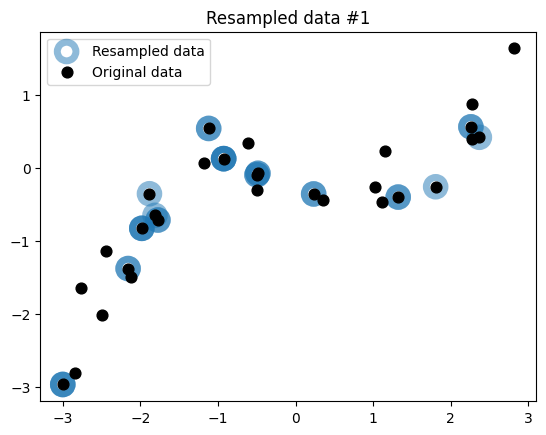

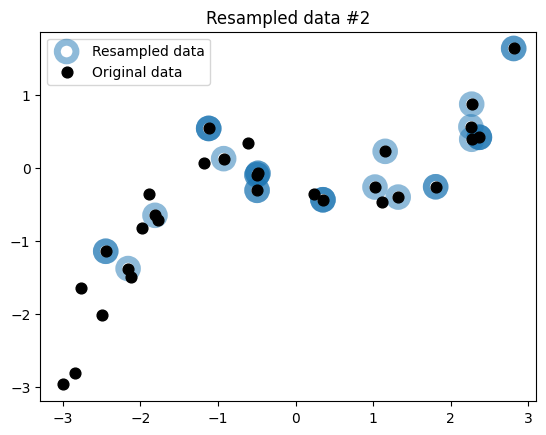

In [69]:
n_bootstraps = 3
for bootstrap_idx in range(n_bootstraps):
    # draw a bootstrap from the original data
    data_bootstrap, target_bootstrap = bootstrap_sample(
        data_train,
        target_train,
    )
    plt.figure()
    plt.scatter(
        data_bootstrap["Feature"],
        target_bootstrap,
        color="tab:blue",
        facecolors="none",
        alpha=0.5,
        label="Resampled data",
        s=180,
        linewidth=5,
    )
    plt.scatter(
        data_train["Feature"],
        target_train,
        color="black",
        s=60,
        alpha=1,
        label="Original data",
    )
    plt.title(f"Resampled data #{bootstrap_idx}")
    plt.legend()

In [70]:
data_train_huge, data_test_huge, target_train_huge = generate_data(
    n_samples=100_000
)
data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
    data_train_huge, target_train_huge
)

ratio_unique_sample = (
    np.unique(data_bootstrap_sample).size / data_bootstrap_sample.size
)
print(
    "Percentage of samples present in the original dataset: "
    f"{ratio_unique_sample * 100:.1f}%"
)

Percentage of samples present in the original dataset: 63.2%


On average, roughly 63.2% of the original data points of the original dataset will be present in a given bootstrap sample. Since the bootstrap sample has the same size as the original dataset, there will be many samples that are in the bootstrap sample multiple times.

Using bootstrap we are able to generate many datasets, all slightly different. We can fit a decision tree for each of these datasets and they all shall be slightly different as well.

In [71]:
bag_of_trees = []
for bootstrap_idx in range(n_bootstraps):
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)

    data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
        data_train, target_train
    )
    tree.fit(data_bootstrap_sample, target_bootstrap_sample)
    bag_of_trees.append(tree)

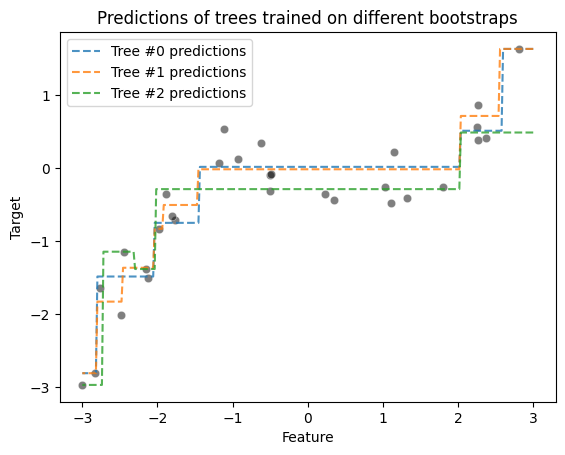

In [72]:
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(
        data_test["Feature"],
        tree_predictions,
        linestyle="--",
        alpha=0.8,
        label=f"Tree #{tree_idx} predictions",
    )

plt.legend()
_ = plt.title("Predictions of trees trained on different bootstraps")

Aggregating

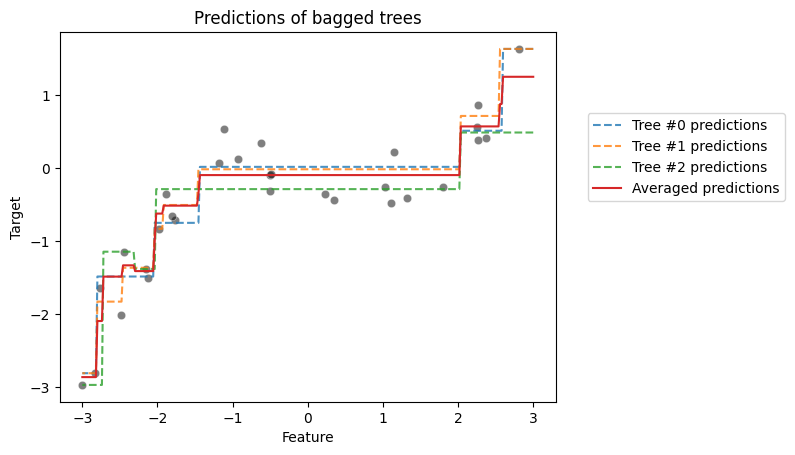

In [73]:
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)

bag_predictions = []
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(
        data_test["Feature"],
        tree_predictions,
        linestyle="--",
        alpha=0.8,
        label=f"Tree #{tree_idx} predictions",
    )
    bag_predictions.append(tree_predictions)

bag_predictions = np.mean(bag_predictions, axis=0)
plt.plot(
    data_test["Feature"],
    bag_predictions,
    label="Averaged predictions",
    linestyle="-",
)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predictions of bagged trees")

So we are almost done, instead of generating bagging by ourself, we can proceed with Random Forest!

#### Random Forest

* Step 1: In the Random forest model, a subset of data points and a subset of features is selected for constructing each decision tree. Simply put, ***n*** random records and ***m*** features are taken from the data set having ***k*** number of records.
* Step 2: Individual decision trees are constructed for each sample.
* Step 3: Each decision tree will generate an output.
* Step 4: Final output is considered based on Majority Voting or Averaging for Classification and regression, respectively.


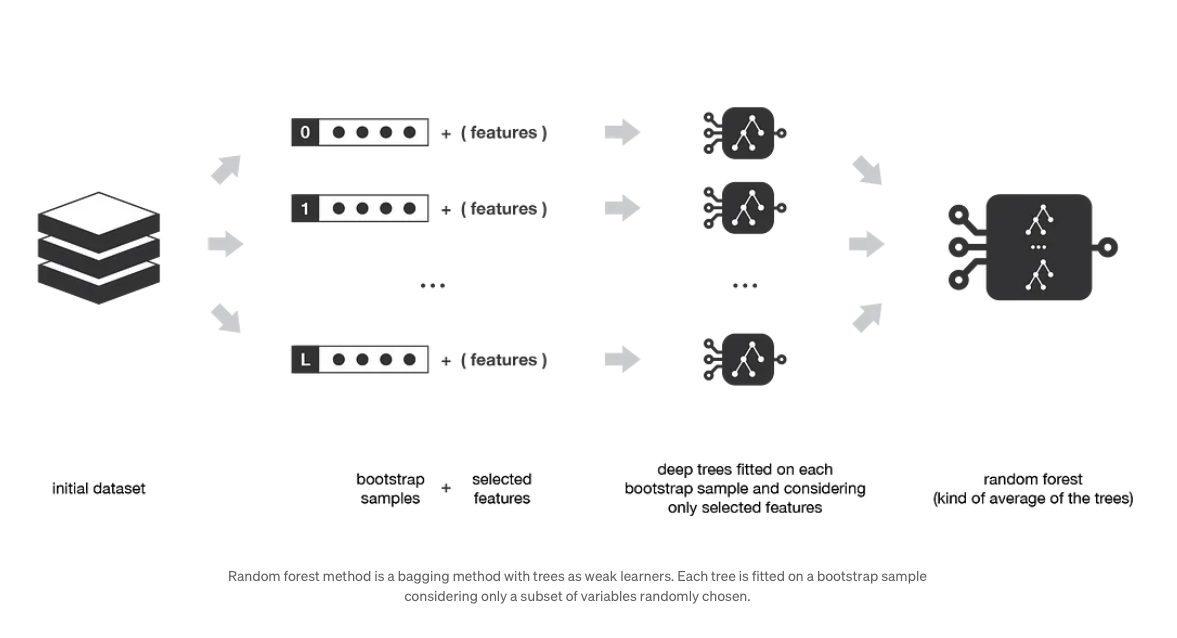

In [77]:
display.Image("data/tree_RF.png")

#### Important Features of Random Forest

* Diversity: Not all attributes/variables/features are considered while making an individual tree; each tree is different.
* Immune to the curse of dimensionality: Since each tree does not consider all the features, the feature space is reduced.
* Parallelization: Each tree is created independently out of different data and attributes. This means we can fully use the CPU to build random forests.
* Train-Test split: In a random forest, we don’t have to segregate the data for train and test as there will always be 30% of the data which is not seen by the decision tree.
* Stability: Stability arises because the result is based on majority voting/ averaging.

### Boosting

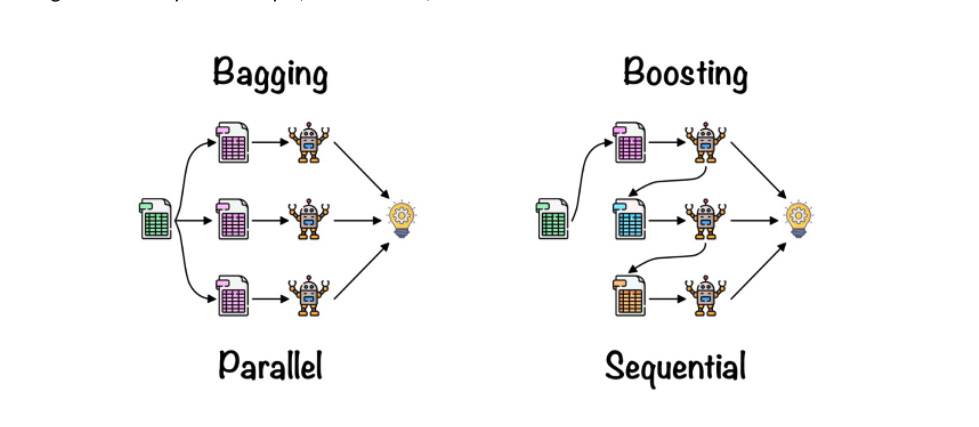

In [79]:
display.Image("data/tree_13.png")

Suppose we have a crappy model  that uses features  to predict target \
A bad but reasonable choice of would be a model that always predicts the mean of *y*:

\begin{align}
\text{F}_{0}\text{(x)} = \hat{y}
\end{align}

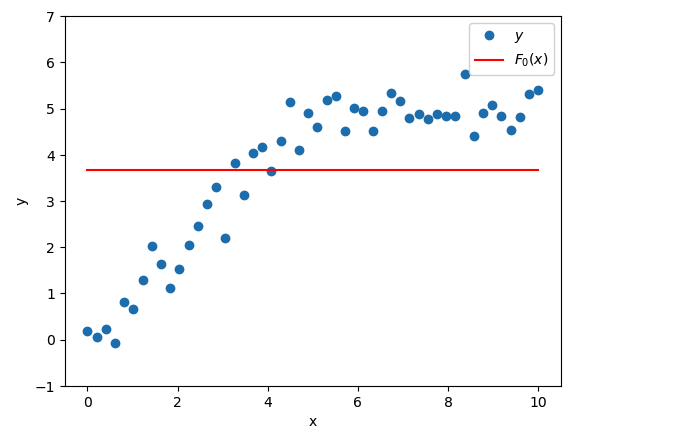

In [5]:
display.Image("data/boosting_1.png")

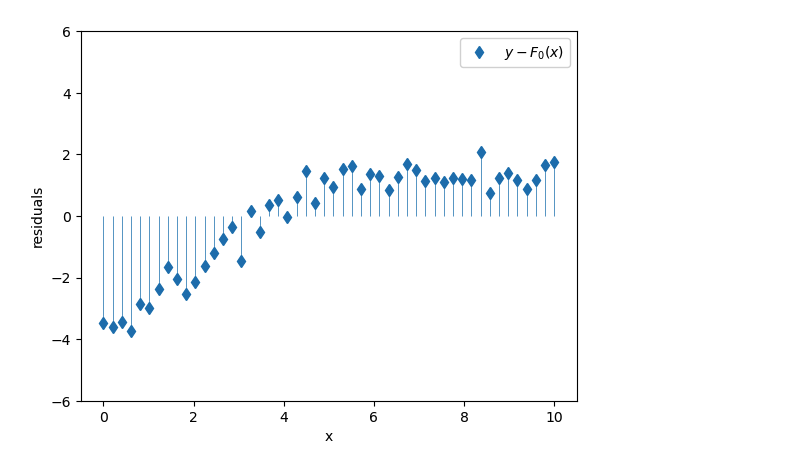

In [6]:
display.Image("data/boosting_2.png")

Well what if I had another bad model that could predict the residuals?

It’s worth noting that the bad of this new model is essential \
in fact in this boosting context, it’s usually called a weak learner. To get a model that’s only slightly better than nothing, let’s use a very simple decision tree with a single split, a.k.a. a stump \
This model basically divides our feature into two regions and predicts the mean value of  for all of the ’s in each region. It might look like this.

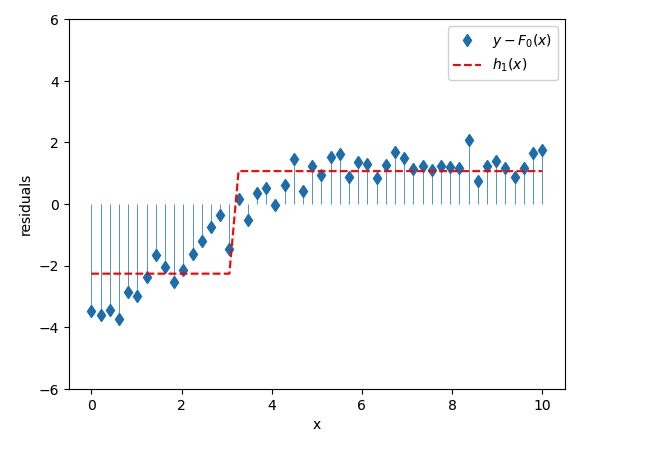

In [7]:
display.Image("data/boosting_3.png")

\begin{align}
\text{F}_{1}\text{(x)} = \text{F}_{0}\text{(x)} + \text{h}_{1}\text{(x)}
\end{align}

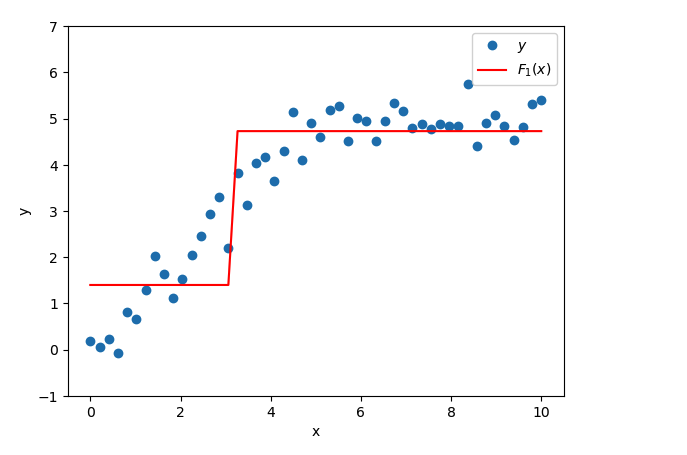

In [8]:
display.Image("data/boosting_4.png")

We can build one more model for predict the residuals from current model 

\begin{align}
\text{F}_{2}\text{(x)} = \text{F}_{1}\text{(x)} + \text{h}_{2}\text{(x)}
\end{align}

If we add  **M** 'weak learners' models constructed in this way to our original model, we might actually end up with a pretty good model that looks like

\begin{align}
\text{F}_{m}\text{(x)} = \text{F}_{0}\text{(x)} + \sum_{m=1}^{M} \text{h}_{m}\text{(x)} 
\end{align}

#### Learning rate


Let’s talk about overfitting. In real life, if we just add our new weak learner directly to our existing composite model, then we’re likely to end up overfitting on our training data. That’s because if we add enough of these weak learners, they’re going to chase down y so closely that all the remaining residuals are pretty much zero, and we will have successfully memorized the training data. To prevent that, we’ll scale them down a bit by a parameter  called the learning rate.



\begin{align}
\text{F}_{m}\text{(x)} = \text{F}_{0}\text{(x)} + \eta * \sum_{m=1}^{M} \text{h}_{m}\text{(x)} 
\end{align}

In [23]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x})

# just random uniform distributions in differnt range

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))

In [29]:
from sklearn.tree import DecisionTreeRegressor

# model hyperparameters
learning_rate = 0.3
n_trees = 10
max_depth = 4

# Training
F0 = y.mean() 
Fm = F0
trees = []
for _ in range(n_trees):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(x, y - Fm)
    Fm += learning_rate * tree.predict(x)
    trees.append(tree)

# Prediction
y_hat = F0 + learning_rate * np.sum([t.predict(x) for t in trees], axis=0)

In [30]:
class GradientBoostingFromScratch():
    
    def __init__(self, n_trees, learning_rate, max_depth=1):
        self.n_trees=n_trees; self.learning_rate=learning_rate; self.max_depth=max_depth;
        
    def fit(self, x, y):
        self.trees = []
        self.F0 = y.mean()
        Fm = self.F0 
        for _ in range(self.n_trees):
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(x, y - Fm)
            Fm += self.learning_rate * tree.predict(x)
            self.trees.append(tree)
            
    def predict(self, x):
        return self.F0 + self.learning_rate * np.sum([tree.predict(x) for tree in self.trees], axis=0)

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

sklearn_gbm = GradientBoostingRegressor(n_estimators =25, learning_rate=0.3, max_depth=1)
sklearn_gbm.fit(x,y)

scratch_gbm = GradientBoostingFromScratch(n_trees=25, learning_rate=0.3, max_depth=1)
scratch_gbm.fit(x,y)

mean_squared_error(y, sklearn_gbm.predict(x)), mean_squared_error(y, scratch_gbm.predict(x))

(23.589546501779942, 23.589546501779946)

#### Bias Variance tradeoff

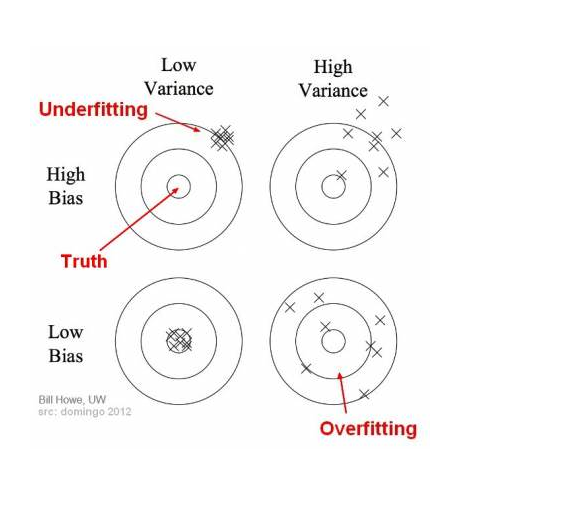

In [76]:
display.Image("data/tree_11.png")

Bagging attempts to incorporate similar learners on small-sample populations and calculates the average of all the predictions. Generally, bagging allows you to use different learners in different populations. By doing so, this method helps to reduce the variance error.

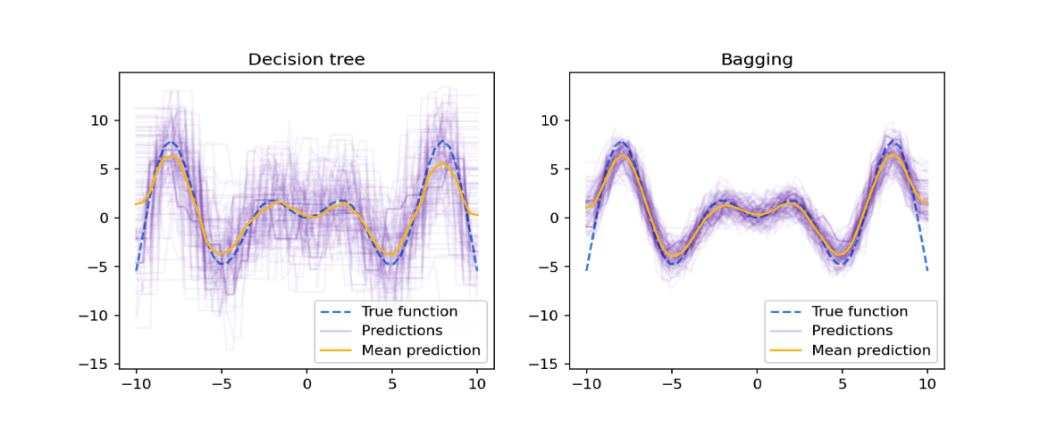

In [81]:
display.Image("data/tree_12.png")


Boosting is an iterative method that fine-tunes the weight of an observation according to the most recent classification. If an observation was incorrectly classified, this method will increase the weight of that observation in the next round (in which the next model will be trained) and will be less prone to misclassification. Similarly, if an observation was classified correctly, then it will reduce its weight for the next classifier. The weight represents how important the correct classification of the specific data point should be, as this enables the sequential classifiers to focus on examples previously misclassified. Generally, boosting reduces the bias error and forms strong predictive models, but at times they may overfit on the training data.